<a href="https://colab.research.google.com/github/VellummyilumVinoth/Aspect_based_sentimental_analysis/blob/main/Aspect_auto_categorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install transformers
!pip install --upgrade keras
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import keras.preprocessing.sequence
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import *
from tqdm import tqdm, trange
from ast import literal_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [5]:
# Step 1: Prepare your dataset
df = pd.read_csv('/content/drive/MyDrive/zidan/aspect_extracted_file.csv')

In [6]:
# Assuming your dataset is stored in X and y variables
df, test_data = train_test_split(df, test_size=0.2)


In [7]:
df

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
8784,OxiClean® Versatile Stain Remover Odor Blaster...,Best product I found to remove odors from work...,Best product I found to remove odors from work...,best product i found to remove odors from work...,"['best', 'product', 'found', 'remove', 'odors'...",['quality'],0,1,0,0,0,0,0
8911,"Pill Pouch Bags - (Pack of 400) 3"" x 2.75"" - B...",These little bags are light plastic and can be...,These little bags are light plastic and can be...,these little bags are light plastic and can be...,"['little', 'bags', 'light', 'plastic', 'reused...","['quality', 'usability']",0,1,0,0,0,0,1
9559,MR.SIGA Professional Window Cleaning Combo - S...,"Good for Cleaning Windows or Mirrors , inside ...","Good for Cleaning Windows or Mirrors , inside ...",good for cleaning windows or mirrors inside o...,"['good', 'cleaning', 'windows', 'mirrors', 'in...",[],0,0,0,0,0,0,0
2565,"Amazon Basics Aluminum Foil, 250 Sq Ft, pack o...","Good for day to day use, but not for secure wr...","Good for day to day use, but not for secure wr...",good for day to day use but not for secure wra...,"['good', 'day', 'day', 'use', 'secure', 'wrapp...","['quality', 'packaging', 'usability']",0,1,0,1,0,0,1
4347,Amazon Basics 24-Pack Rechargeable AA NiMH Hig...,I have previously tested the,I have previously tested the,i have previously tested the,"['previously', 'tested']",[],0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11053,2 Pack Pumice Stone for Toilet Cleaning with E...,The tool works fairly well for removing hard s...,The tool works fairly well for removing hard s...,the tool works fairly well for removing hard s...,"['tool', 'works', 'fairly', 'well', 'removing'...","['quality', 'usability']",0,1,0,0,0,0,1
4129,"Glade Solid Air Freshener, Deodorizer for Home...",Was supposed to receive 2 but only got 1. Not...,Was supposed to receive 2 but only got 1. Not...,was supposed to receive 2 but only got 1 not ...,"['supposed', 'receive', '2', 'got', '1', 'goin...","['delivery cost', 'packaging']",0,0,1,1,0,0,0
5218,Duracell Coppertop AA Batteries with Power Boo...,I needed batteries for my tv remote and clock....,I needed batteries for my tv remote and clock....,i needed batteries for my tv remote and clock ...,"['needed', 'batteries', 'tv', 'remote', 'clock...",['price'],1,0,0,0,0,0,0
9180,50th Birthday Gifts for Men and Women - Happy ...,HAHAHA she was laughing :),HAHAHA she was laughing :),hahaha she was laughing,"['hahaha', 'laughing']",[],0,0,0,0,0,0,0


In [8]:
columns_to_drop = ['product_name', 'review','review_without_emoji', 'aspects', 'preprocess_text1']
df.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
df.head()

,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability
8784,best product i found to remove odors from work...,0,1,0,0,0,0,0
8911,these little bags are light plastic and can be...,0,1,0,0,0,0,1
9559,good for cleaning windows or mirrors inside o...,0,0,0,0,0,0,0
2565,good for day to day use but not for secure wra...,0,1,0,1,0,0,1
4347,i have previously tested the,0,0,0,0,0,0,0


In [10]:
print('Unique comments: ', df.preprocess_text.nunique() == df.shape[0])
print('Null values: ', df.isnull().values.any())

Unique comments:  False
Null values:  False


In [11]:
print('average sentence length: ', df.preprocess_text.str.split().str.len().mean())
print('stdev sentence length: ', df.preprocess_text.str.split().str.len().std())

average sentence length:  46.81254946297343
stdev sentence length:  87.69528005895702


In [12]:
cols = df.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['price', 'quality', 'delivery cost', 'packaging', 'design', 'customer service', 'usability']


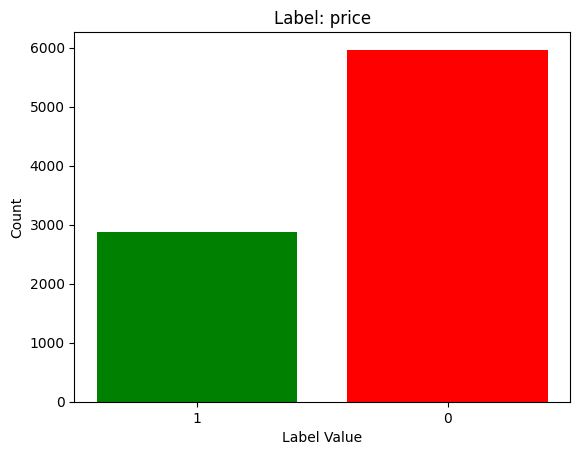

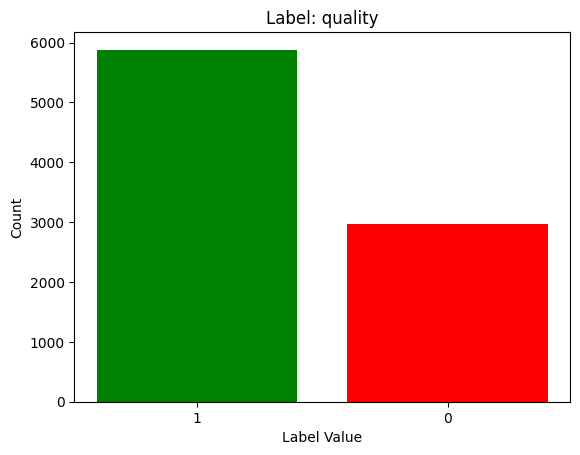

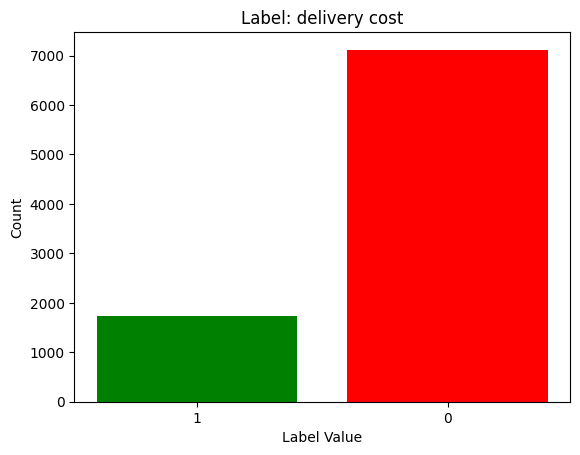

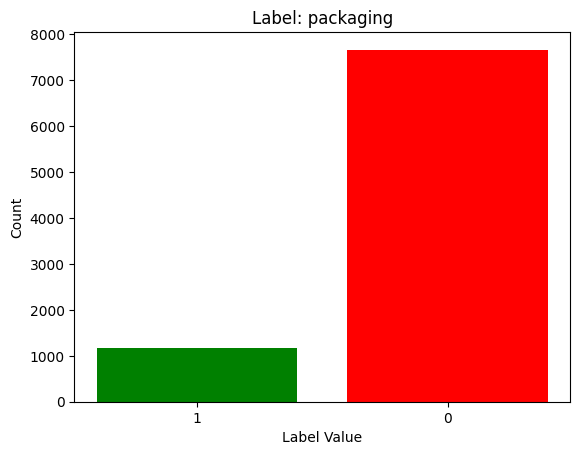

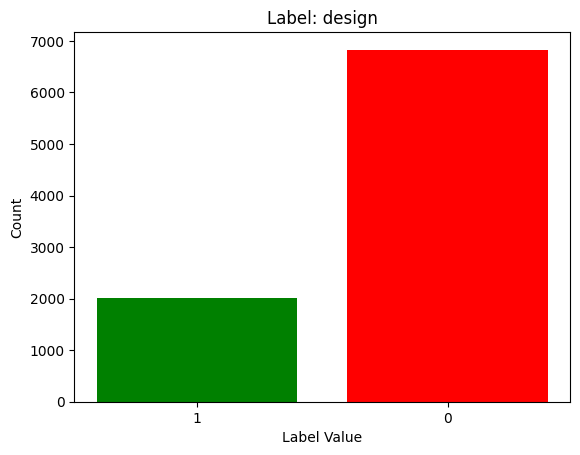

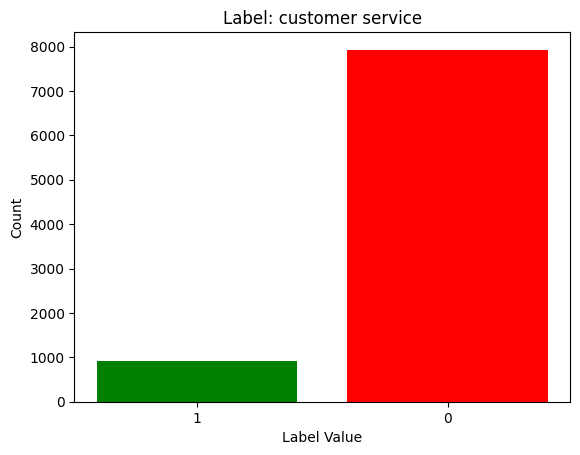

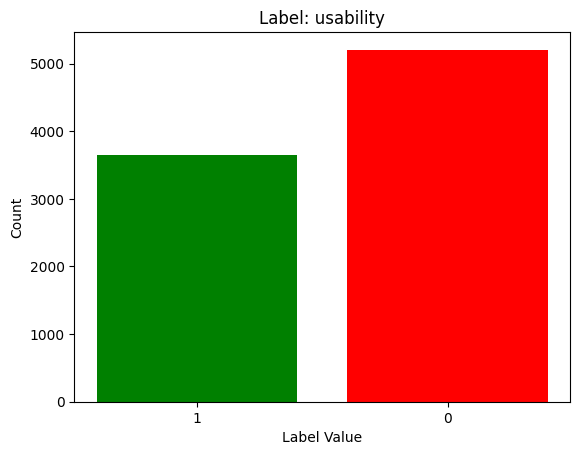

In [13]:
import matplotlib.pyplot as plt
# Count of 1 per label
label_counts_1 = df[label_cols].sum()

# Count of 0 per label
label_counts_0 = df[label_cols].eq(0).sum()

# Create separate graphs for each aspect label
colors_1 = ['green' for _ in range(num_labels)]  # Color for 1 values
colors_0 = ['red' for _ in range(num_labels)]    # Color for 0 values

for i, aspect_label in enumerate(label_cols):
    fig, ax = plt.subplots()
    ax.bar(['1', '0'], [label_counts_1[i], label_counts_0[i]], color=[colors_1[i], colors_0[i]])
    ax.set_xlabel('Label Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Label: {aspect_label}')
    plt.show()

In [14]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle rows

In [15]:
df['labels'] = list(df[label_cols].values)
df.head()

,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability,labels
0,purchased this based on stellar reviews and im...,1,1,1,0,0,0,0,"[1, 1, 1, 0, 0, 0, 0]"
1,got the batteries in quickly and they worked g...,0,1,1,0,0,1,0,"[0, 1, 1, 0, 0, 1, 0]"
2,like that the size is much bigger than the ori...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
3,for the savings this is a very good buy they a...,1,1,0,0,1,0,0,"[1, 1, 0, 0, 1, 0, 0]"
4,i used the mop for mopping my houseit was a s...,1,1,0,0,1,0,1,"[1, 1, 0, 0, 1, 0, 1]"


In [16]:
labels = list(df.labels.values)
comments = list(df.preprocess_text.values)

In [17]:
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(comments,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defau

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [18]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [19]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [8408, 7410, 6602, 6042, 6034, 5844, 4820, 3156]


In [20]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [21]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

<ipython-input-21-8effe635eb5d>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_labels = torch.tensor(train_labels)


In [22]:
# Select a batch size for training. We will use 32 here to avoid memory issues.
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

In [24]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "trans

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/model.safetensors
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification mod

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [25]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [26]:
optimizer = AdamW(optimizer_grouped_parameters,lr=3e-5,correct_bias=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [27]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    # loss_func = BCELoss()
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.3847802129974327


Epoch:  33%|███▎      | 1/3 [02:36<05:12, 156.28s/it]

F1 Validation Accuracy:  86.42898217366303
Flat Validation Accuracy:  60.85972850678733
Train loss: 0.14815981138542475


Epoch:  67%|██████▋   | 2/3 [05:11<02:35, 155.94s/it]

F1 Validation Accuracy:  95.26416643854367
Flat Validation Accuracy:  85.40723981900452
Train loss: 0.07702858844794423


Epoch: 100%|██████████| 3/3 [07:47<00:00, 155.72s/it]

F1 Validation Accuracy:  96.8240817453742
Flat Validation Accuracy:  90.27149321266968


In [28]:
import os

output_dir = os.path.expanduser('/content/drive/MyDrive/zidan/finetuned_bert')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print('Saved')

Configuration saved in /content/drive/MyDrive/zidan/finetuned_bert/config.json
Model weights saved in /content/drive/MyDrive/zidan/finetuned_bert/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/zidan/finetuned_bert/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/zidan/finetuned_bert/special_tokens_map.json


Saved


## Load and Preprocess Test Data

In [29]:
test_data.head()

,product_name,review,review_without_emoji,preprocess_text,preprocess_text1,aspects,price,quality,delivery cost,packaging,design,customer service,usability
1816,Swiffer Wetjet Heavy Duty Mop Pad Refills for ...,Worked well,Worked well,worked well,"['worked', 'well']",['quality'],0,1,0,0,0,0,0
8849,ARECTECH Lighter Rechargeable Lighter Electric...,"If you just need to light a candle wick, this ...","If you just need to light a candle wick, this ...",if you just need to light a candle wick this w...,"['need', 'light', 'candle', 'wick', 'work', 'f...",['quality'],0,1,0,0,0,0,0
9598,"[400 Count] Settings Plastic White Forks, Prac...",These (and their packages of spoons and forks)...,These (and their packages of spoons and forks)...,these and their packages of spoons and forks a...,"['packages', 'spoons', 'forks', 'great', 'valu...","['price', 'packaging']",1,0,0,1,0,0,0
1949,"OxiClean Laundry Stain Remover Refill, 56 Oz","I love this OxyClean stain remover, especially...","I love this OxyClean stain remover, especially...",i love this oxyclean stain remover especially ...,"['love', 'oxyclean', 'stain', 'remover', 'espe...","['quality', 'delivery cost', 'packaging', 'usa...",0,1,1,1,0,0,1
7634,Concession Essentials 100 Count 6oz Snow Cone ...,like the shape and colour,like the shape and colour,like the shape and colour,"['like', 'shape', 'colour']",[],0,0,0,0,0,0,0


In [30]:
columns_to_drop = ['product_name', 'aspects', 'review','review_without_emoji','preprocess_text1']
test_data.drop(columns_to_drop, axis=1, inplace=True)

test_label_cols = list(test_data.columns[1:])
print('Null values:', test_data.isnull().values.any())  # Should not be any null sentences or labels
print('Same columns between train and test:', label_cols == test_label_cols)  # Columns should be the same

test_data[test_label_cols] = -1  # Set label column values to -1

test_data.head()


Null values: False
Same columns between train and test: True


,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability
1816,worked well,-1,-1,-1,-1,-1,-1,-1
8849,if you just need to light a candle wick this w...,-1,-1,-1,-1,-1,-1,-1
9598,these and their packages of spoons and forks a...,-1,-1,-1,-1,-1,-1,-1
1949,i love this oxyclean stain remover especially ...,-1,-1,-1,-1,-1,-1,-1
7634,like the shape and colour,-1,-1,-1,-1,-1,-1,-1


In [31]:
test_data = test_data.replace(-1, 0)  # Change -1 to 0 in the entire DataFrame

test_data = test_data[~test_data[test_label_cols].eq(-1).any(axis=1)]  # Remove irrelevant rows/comments with -1 values
test_data['labels'] = list(test_data[test_label_cols].values)
test_data.head()


,preprocess_text,price,quality,delivery cost,packaging,design,customer service,usability,labels
1816,worked well,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
8849,if you just need to light a candle wick this w...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
9598,these and their packages of spoons and forks a...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
1949,i love this oxyclean stain remover especially ...,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"
7634,like the shape and colour,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0]"


In [32]:
# Gathering input data
test_labels = list(test_data.labels.values)
test_comments = list(test_data.preprocess_text.values)

In [33]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_comments,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [34]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Prediction and Metics

In [35]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Variables to gather full output
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(validation_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Calculate Accuracy
threshold = 0.50
pred_bools = [pl>threshold for pl in pred_labels]
true_bools = [tl==1 for tl in true_labels]
f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
flat_accuracy = accuracy_score(true_bools, pred_bools)*100

print('Test F1 Accuracy: ', val_f1_accuracy)
print('Test Flat Accuracy: ', val_flat_accuracy)

clf_report = classification_report(true_bools,pred_bools,target_names=test_label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report

Test F1 Accuracy:  96.8240817453742
Test Flat Accuracy:  90.27149321266968


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Output Dataframe

In [36]:
idx2label = dict(zip(range(7),label_cols))
print(idx2label)

{0: 'price', 1: 'quality', 2: 'delivery cost', 3: 'packaging', 4: 'design', 5: 'customer service', 6: 'usability'}


In [37]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [38]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [39]:
# Decoding input ids to reviews
reviews = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [40]:
# Converting lists to df
comparisons_df = pd.DataFrame({'reviews': reviews,'pred_labels':pred_label_texts})
comparisons_df.to_csv('/content/drive/MyDrive/zidan/test_predictions.csv')
comparisons_df


,reviews,pred_labels
0,good product and good value,[price]
1,gets my dishes clean,[]
2,these are high quality xtra sturdy cups someon...,"[quality, customer service, usability]"
3,i go through tissues like crazy i hate some of...,"[quality, design, usability]"
4,i love this product but the dye they used to t...,"[quality, delivery cost, usability]"
...,...,...
879,great fit and quality,[quality]
880,i liked this so i came back a month later to b...,[price]
881,i wouldnt say this is for deep cleaning but it...,"[price, quality, usability]"
882,these were beautiful highquality thick napkins,[design]
